# ALGORITHMS FOR COLLECTIVE OPERATION ANALYSIS

Import necessary libraries

In [1]:
import pandas as pd
import os

from utilities_pr1 import theory_and_experiment_plot_with_errors, map3d_grid
from utilities_pr1 import build_intercore_latency_matrix
from utilities_pr1 import compute_linear_broadcast_time, compute_chain_broadcast_latency, compute_binary_tree_broadcast_latency
from utilities_pr1 import binary_tree_reduce_latency, binomial_tree_reduce_latency, rabenseifner_reduce_latency

Load the data

In [2]:
path = r"C:\Users\matte\Documents\HPC\FINAL\HighPerformanceComputing-Monitoring-and-Parallel-Coding\Project 1\output"

df_broad_fix1 = pd.read_csv(os.path.join(path, "broadcast_fixed", "broadcast_algo1_fixed_core.csv"))
df_broad_fix2_0 = pd.read_csv(os.path.join(path, "broadcast_fixed", "broadcast_algo2_fixed_core.csv"))
df_broad_fix2_1 = pd.read_csv(os.path.join(path, "broadcast_fixed", "broadcast_algo2_fixed_core_secondpart.csv"))
df_broad_fix2 = pd.concat([df_broad_fix2_0.iloc[:-1:, :], df_broad_fix2_1], axis = 0)
df_broad_fix2.reset_index(inplace=True, drop=True)
df_broad_fix3 = pd.read_csv(os.path.join(path, "broadcast_fixed", "broadcast_algo3_fixed_core.csv"))

df_broad_var1 = pd.read_csv(os.path.join(path, "broadcast_var", "broadcast_algo1_variable_core.csv"))
df_broad_var2 = pd.read_csv(os.path.join(path, "broadcast_var", "broadcast_algo2_variable_core.csv"))
df_broad_var3 = pd.read_csv(os.path.join(path, "broadcast_var", "broadcast_algo3_variable_core.csv"))

df_reduce_fix1 = pd.read_csv(os.path.join(path, "reduce_fixed", "reduce_algo1_fixed_core.csv"))
df_reduce_fix2 = pd.read_csv(os.path.join(path, "reduce_fixed", "reduce_algo2_fixed_core.csv"))
df_reduce_fix3 = pd.read_csv(os.path.join(path, "reduce_fixed", "reduce_algo3_fixed_core.csv"))

df_reduce_var1 = pd.read_csv(os.path.join(path, "reduce_var", "reduce_algo1_variable_core.csv"))
df_reduce_var2 = pd.read_csv(os.path.join(path, "reduce_var", "reduce_algo2_variable_core.csv"))
df_reduce_var3 = pd.read_csv(os.path.join(path, "reduce_var", "reduce_algo3_variable_core.csv"))


# Latency to 10e-6 seconds
df_broad_fix1['Latency'] = df_broad_fix1['Latency'] * (10**-6)
df_broad_fix2['Latency'] = df_broad_fix2['Latency'] * (10**-6)
df_broad_fix3['Latency'] = df_broad_fix3['Latency'] * (10**-6)
df_broad_var1['Latency'] = df_broad_var1['Latency'] * (10**-6)
df_broad_var2['Latency'] = df_broad_var2['Latency'] * (10**-6)
df_broad_var3['Latency'] = df_broad_var3['Latency'] * (10**-6)
df_reduce_fix1['Latency'] = df_reduce_fix1['Latency'] * (10**-6)
df_reduce_fix2['Latency'] = df_reduce_fix2['Latency'] * (10**-6)
df_reduce_fix3['Latency'] = df_reduce_fix3['Latency'] * (10**-6)
df_reduce_var1['Latency'] = df_reduce_var1['Latency'] * (10**-6)
df_reduce_var2['Latency'] = df_reduce_var2['Latency'] * (10**-6)
df_reduce_var3['Latency'] = df_reduce_var3['Latency'] * (10**-6)

In [3]:
LATENCY_MATRIX = build_intercore_latency_matrix()

## Broadcast Algorithms

### Basic Linear

The **Basic Linear algorithm total communication time** based on number of processes $n$ is:


$$T(n) = \max_{p=1}^{n-1} T_{r \rightarrow p} + O \cdot n$$

with:
- $T_{r \rightarrow i}$ is the communication time from root process to process $p$
- $O$ is the overhead factor per process (time to handle/process the message)


In [4]:
# Model predictions across different process counts
linear_broadcast_predictions = {}
for n_processes in range(2, 257):  # Sweep from 2 to 256 processes
    linear_broadcast_predictions[n_processes] = compute_linear_broadcast_time(
        comm_latency_matrix=LATENCY_MATRIX,
        process_count=n_processes,
        source_rank=0,
        processing_overhead=0.11e-6
    )

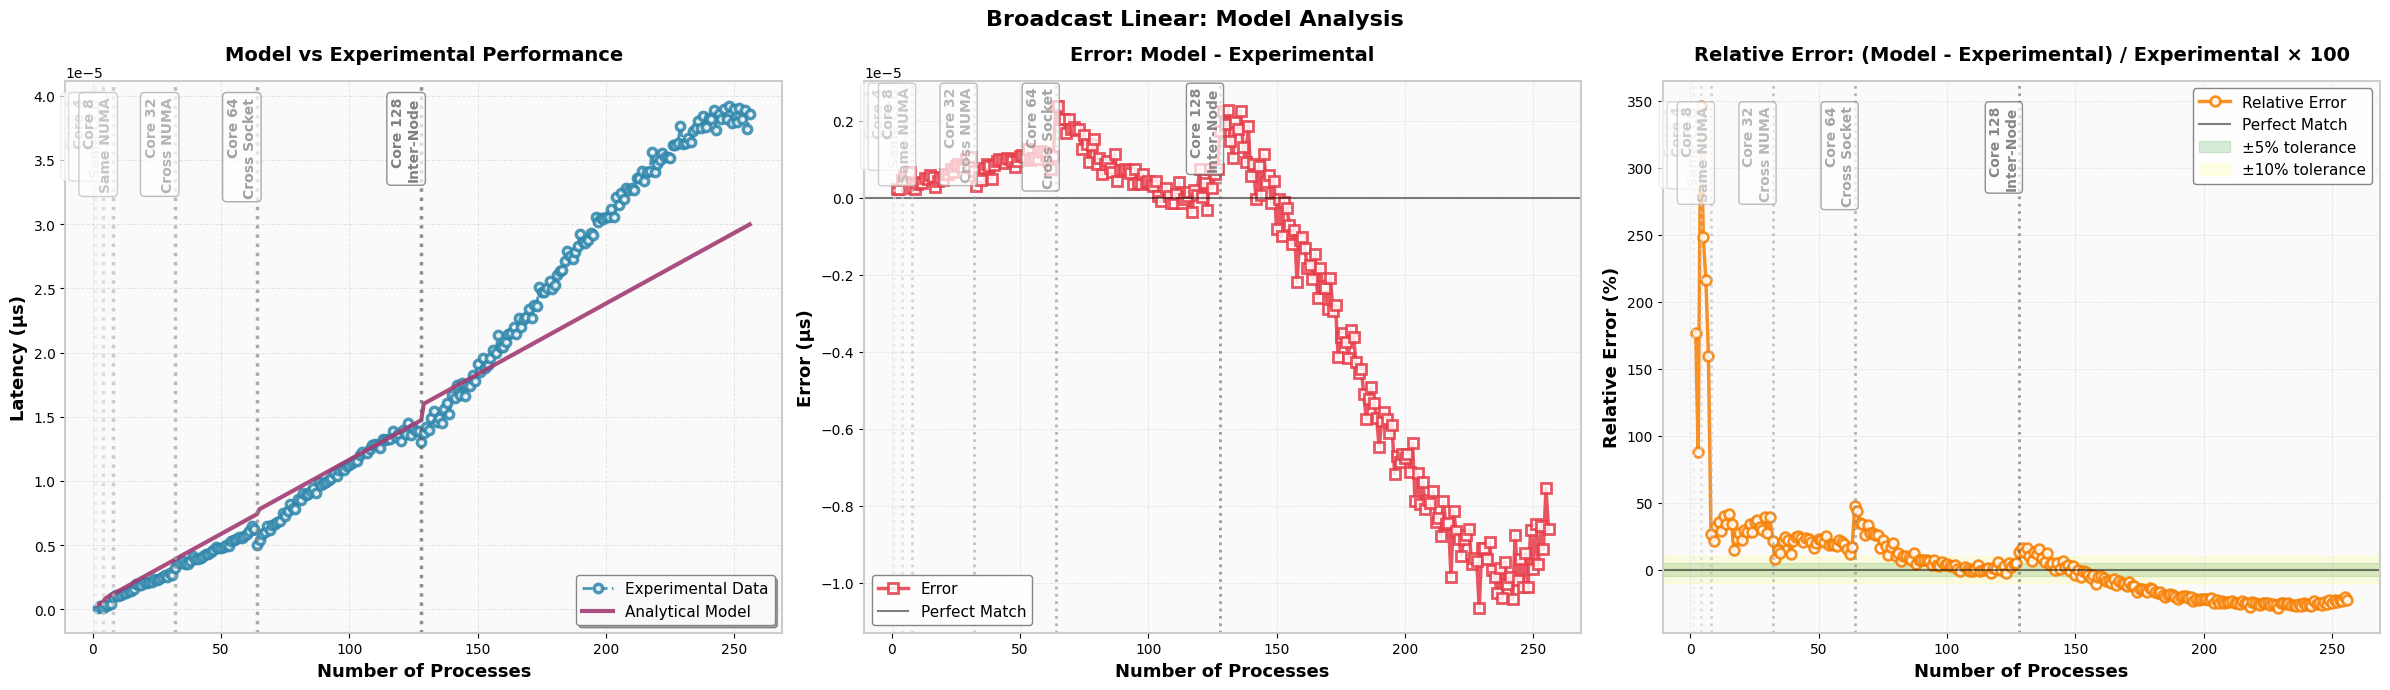

In [5]:
theory_and_experiment_plot_with_errors(df_broad_fix1, linear_broadcast_predictions, 'Broadcast Linear',position_main='best', position_abs='lower left', position_rel='upper right')

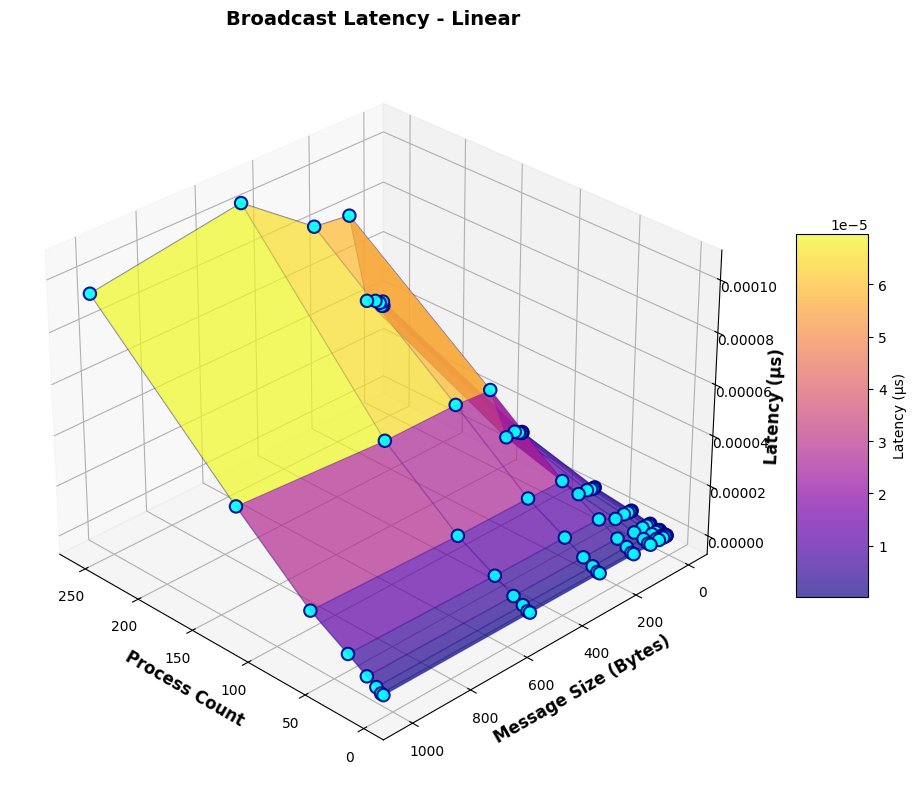

In [6]:
map3d_grid(df_broad_var1, "Broadcast Latency - Linear")

### Pipeline

The **Pipeline algorithm total communication time** based on number of processes $n$ is:

$$T(n) = \sum_{p=0}^{n-2} T_{p \rightarrow p+1}$$

with:
- $T_{p \rightarrow p+1}$ is the communication time from process $p$ to process $p+1$

In [7]:
# Model predictions across different process counts
pipeline_broadcast_predictions = {}
for n_processes in range(2, 257):  # Sweep from 2 to 256 processes
    pipeline_broadcast_predictions[n_processes] = compute_chain_broadcast_latency(
        comm_matrix=LATENCY_MATRIX,
        process_count=n_processes,
        source_rank=0
    )

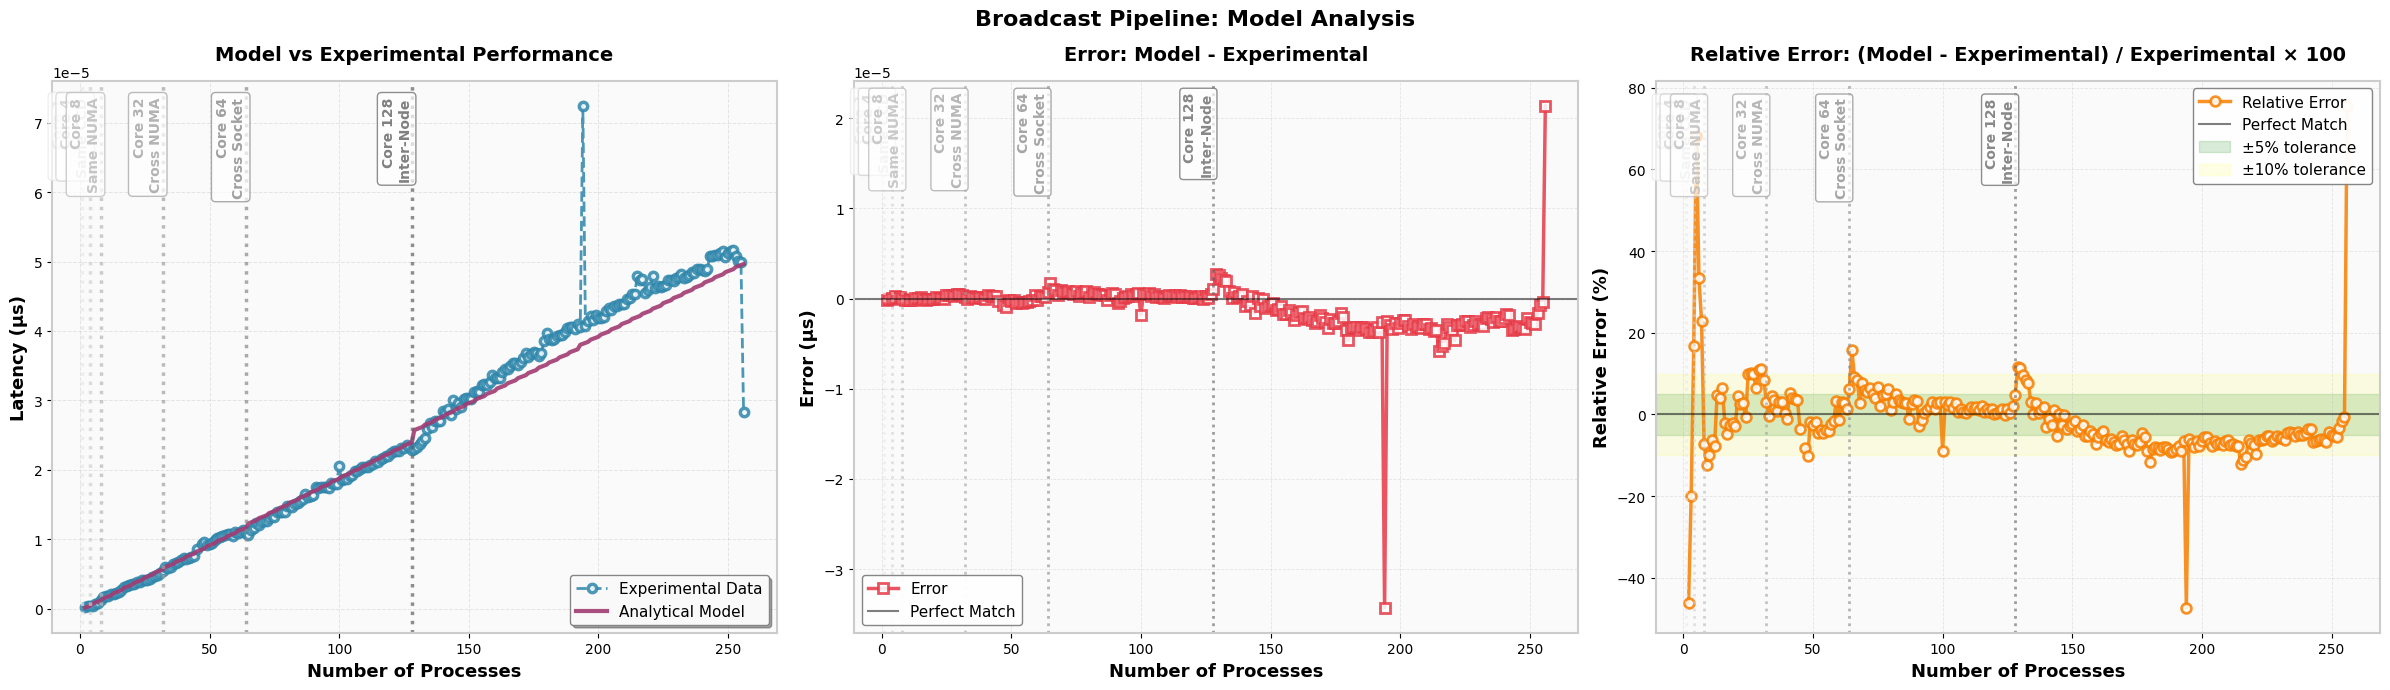

In [8]:
theory_and_experiment_plot_with_errors(df_broad_fix2, pipeline_broadcast_predictions, 'Broadcast Pipeline',position_main='best', position_abs='lower left', position_rel='upper right')

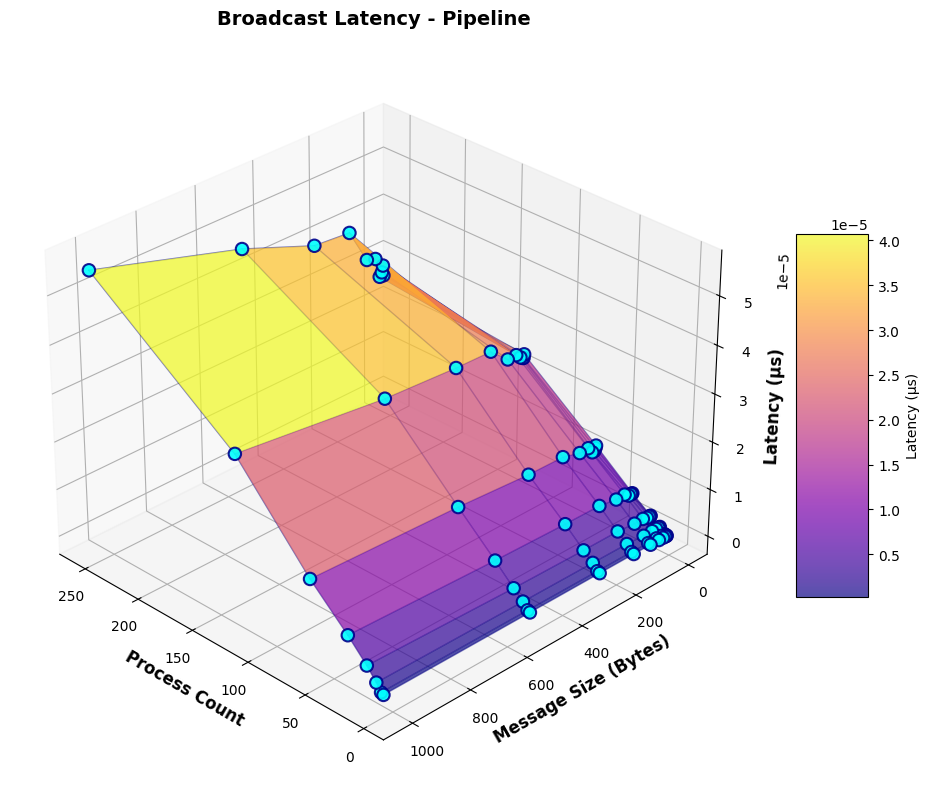

In [9]:
map3d_grid(df_broad_var2, "Broadcast Latency - Pipeline")

### Binary Tree

The **Binary Tree algorithm total communication time** based on number of processes $n$ is:


$$T(n) = \sum_{lv=1}^{height_{tree}} \max_{node \in S(lv)} T_{P(node) \rightarrow node} + O \cdot n$$

with:

- $height_{tree}$ is the computed tree height, which by definition is $\lceil\log_{2}(n)\rceil$
- $S(lv)$ represents all nodes at level $lv$
- $P(node)$ represents the parent of the node, higher leaf in the subtree.
- $T_{P(node) \rightarrow node}$ is the communication time from parent to node
- $O$ is the overhead factor per process  (time to handle/process the message)

In [10]:
# Model predictions across different process counts
tree_broadcast_predictions = {}
for n_processes in range(2, 257):  # Sweep from 2 to 256 processes
    tree_broadcast_predictions[n_processes] = compute_binary_tree_broadcast_latency(
        comm_matrix=LATENCY_MATRIX,
        process_count=n_processes,
        processing_overhead=0.015e-6
    )

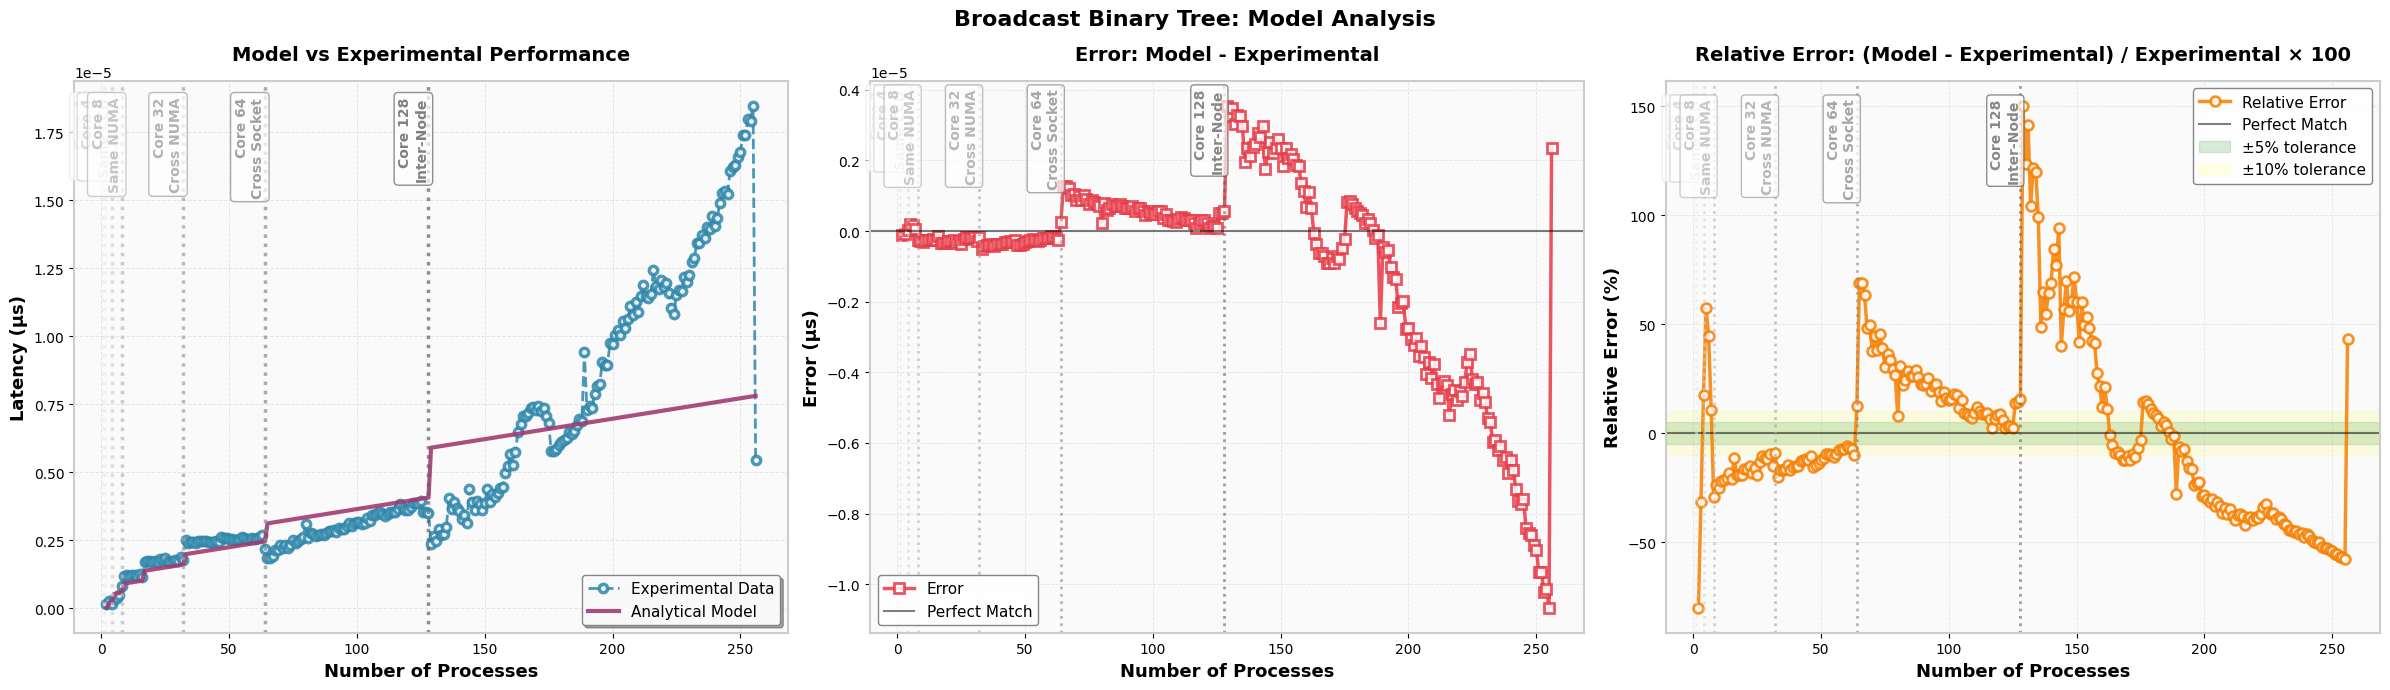

In [11]:
theory_and_experiment_plot_with_errors(df_broad_fix3, tree_broadcast_predictions, 'Broadcast Binary Tree',position_main='best', position_abs='lower left', position_rel='upper right')

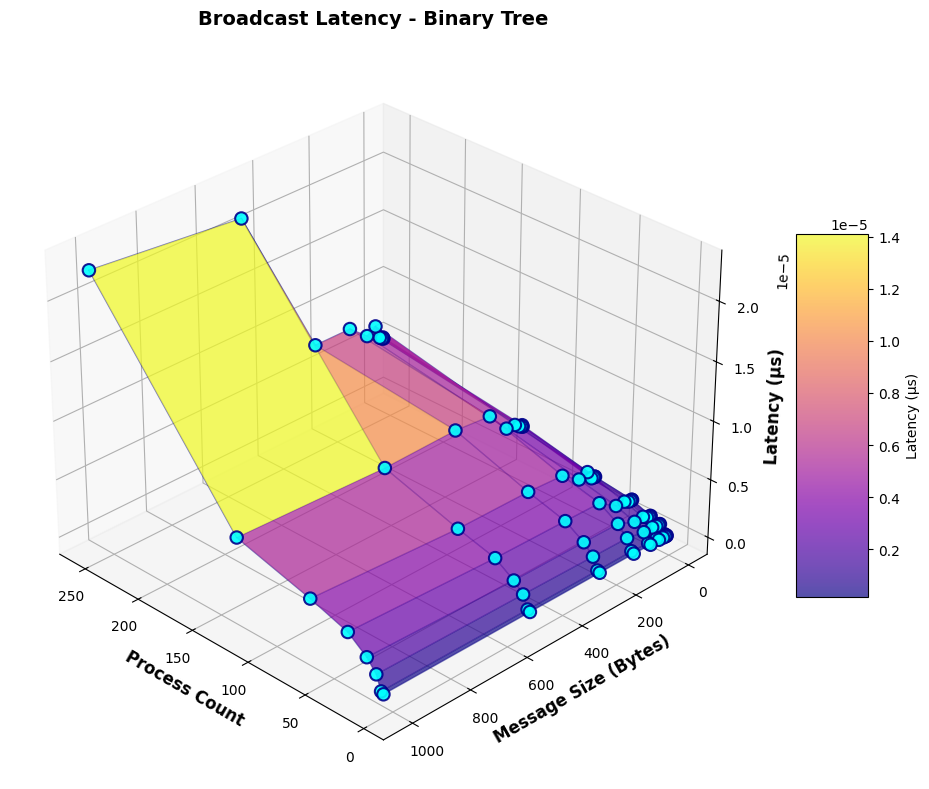

In [12]:
map3d_grid(df_broad_var3, "Broadcast Latency - Binary Tree")

## Reduce Algorithms

### Binary

The **Binary algorithm total communication time** based on number of processes $n$ is:

$$T(n) = \sum_{lv=0}^{\log_2 n - 1} \max_{R} \left\{T(R + 2^{lv} \to R) \right\}$$

with:
- $lv$ is the considered level in the tree (ranges from 0 to $\log_2 n - 1$)
- $R$ is the receiver rank (iterates over valid receiver positions at each level)
- $2^lv$ is the distance between sender and receiver at level $lv$ (so the step done)
- $R + 2^{lv}$ is the sender rank


At each level, multiple pairs communicate in parallel. The bottleneck (maximum latency) at that level determines the total time for that level. The communication pattern follows a full binary tree, with $\log_2 n$ levels. At each level, the slowest communication dominates.


In [13]:
# Model predictions across different process counts
binary_reduce_predictions = {}
for n_processes in range(2, 257):  # Sweep from 2 to 256 processes
    binary_reduce_predictions[n_processes] = binary_tree_reduce_latency(
        matrix_times=LATENCY_MATRIX,
        num_cores=n_processes
    )

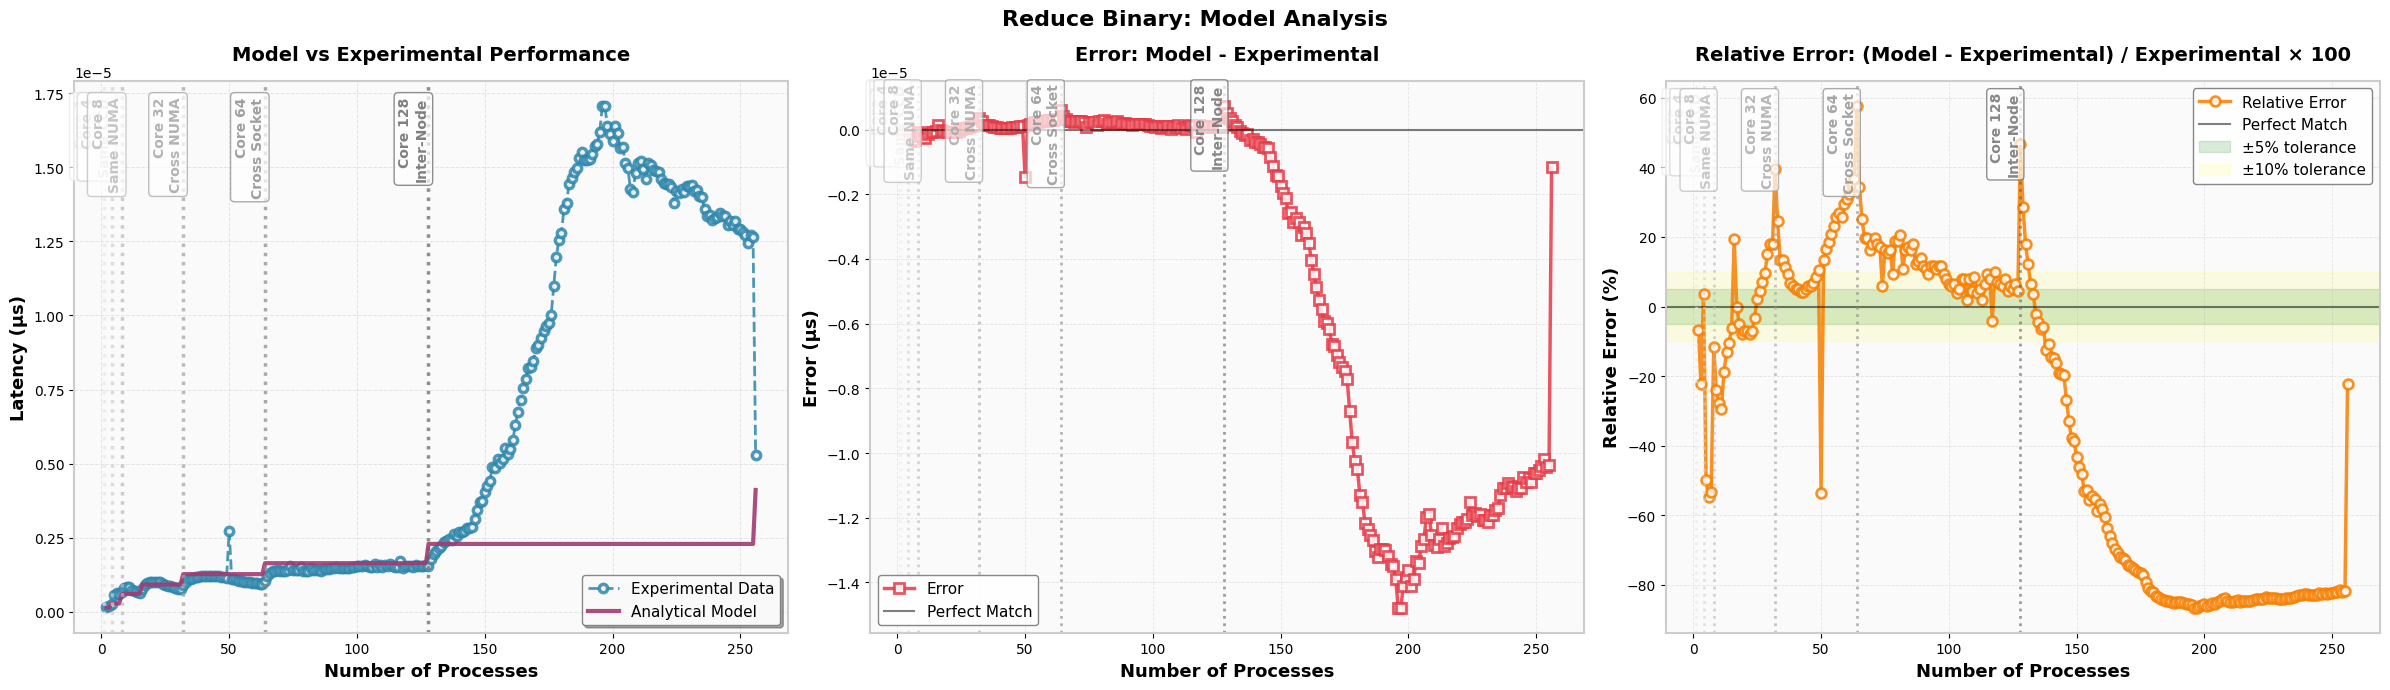

In [14]:
theory_and_experiment_plot_with_errors(df_reduce_fix1, binary_reduce_predictions, 'Reduce Binary',position_main='best', position_abs='lower left', position_rel='upper right')

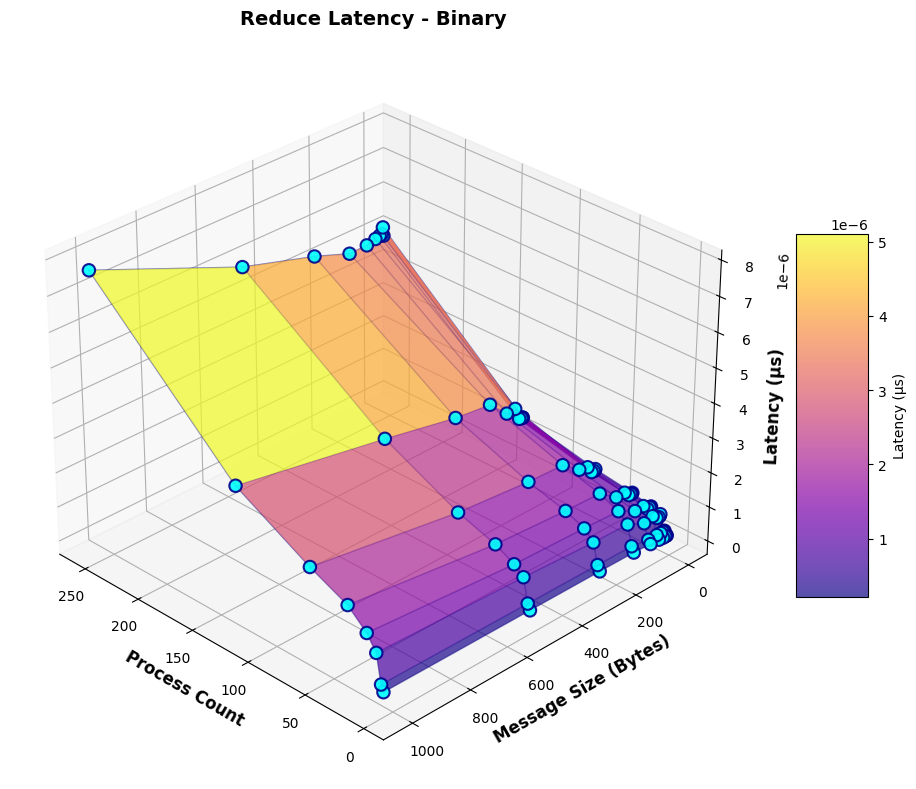

In [15]:
map3d_grid(df_reduce_var1, "Reduce Latency - Binary")

### Binomial

The **Binomial algorithm total communication time** based on number of processes $n$ is:



$$T(n) = \sum_{i=0}^{\log_2 n - 1} \ T(2^i \to 0)$$

with: 
- $2^i$ is the sender rank at step $i$
- Root rank is rank 0

**Explanation:** This is a root-centric pattern where each power-of-2 rank sends directly to the root sequentially. Communications happen one after another, not in parallel. At each step $i = 0, \ldots, \log_2 n - 1$, one message is sent from rank $2^i$ to the root.


In [16]:
# Model predictions across different process counts
binomial_reduce_predictions = {}
for n_processes in range(2, 257):  # Sweep from 2 to 256 processes
    binomial_reduce_predictions[n_processes] = binomial_tree_reduce_latency(
        matrix_times=LATENCY_MATRIX,
        num_cores=n_processes
    )

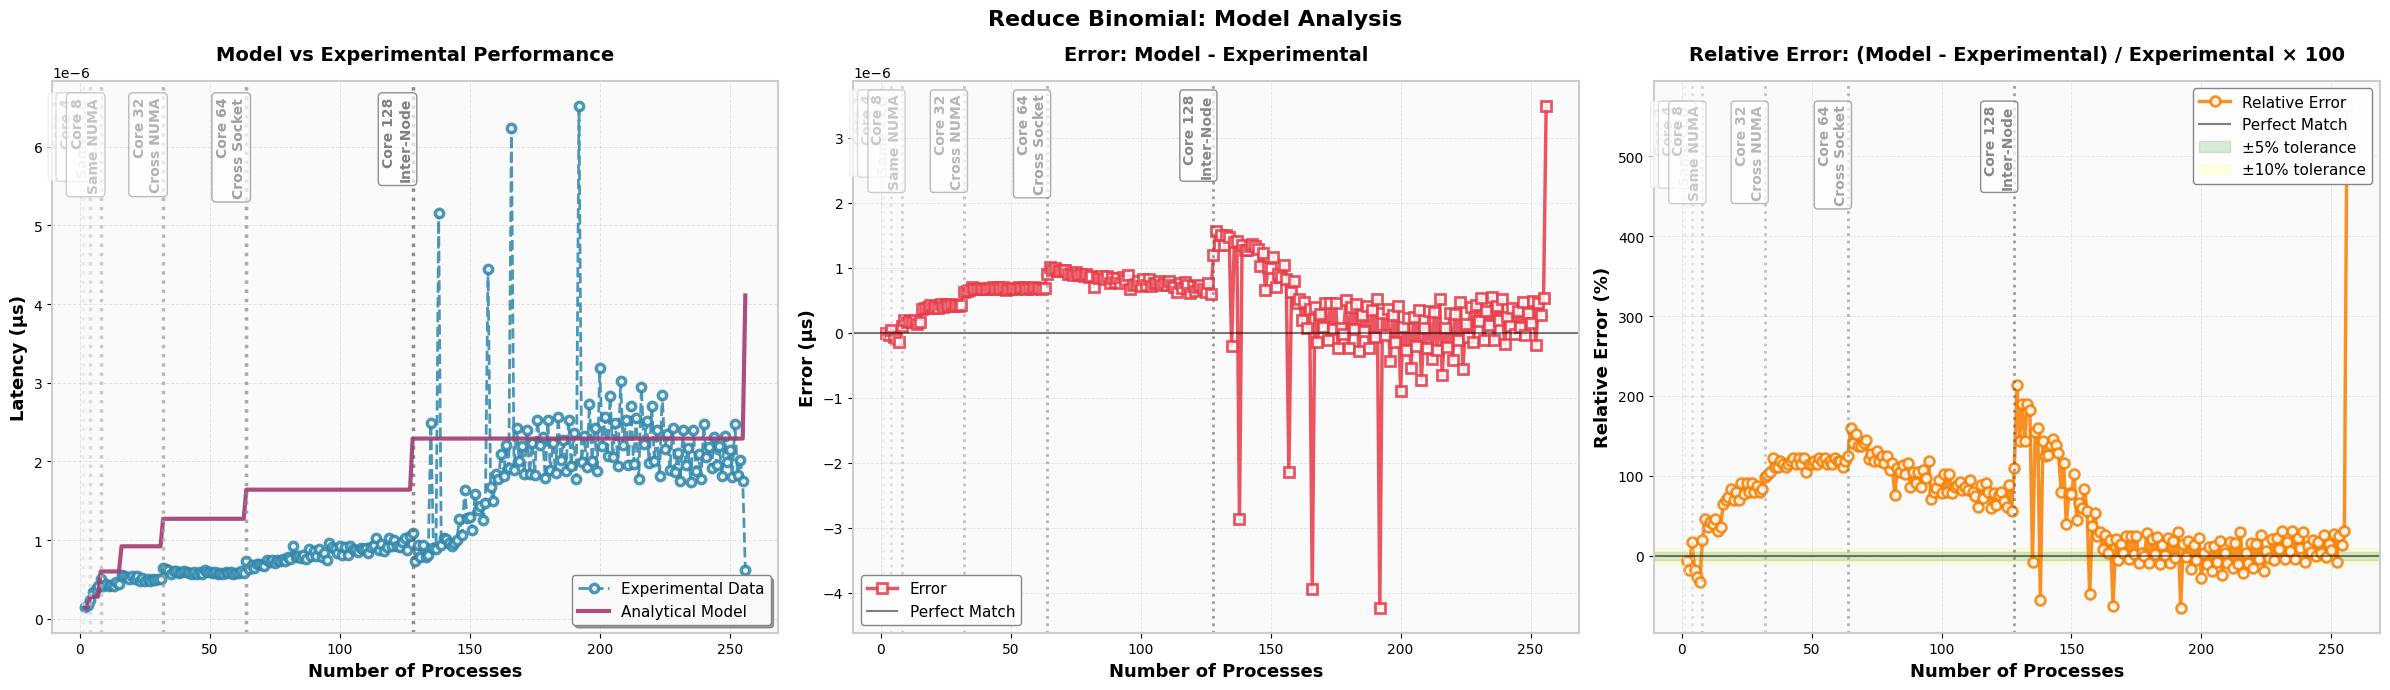

In [17]:
theory_and_experiment_plot_with_errors(df_reduce_fix2, binomial_reduce_predictions, 'Reduce Binomial',position_main='best', position_abs='lower left', position_rel='upper right')

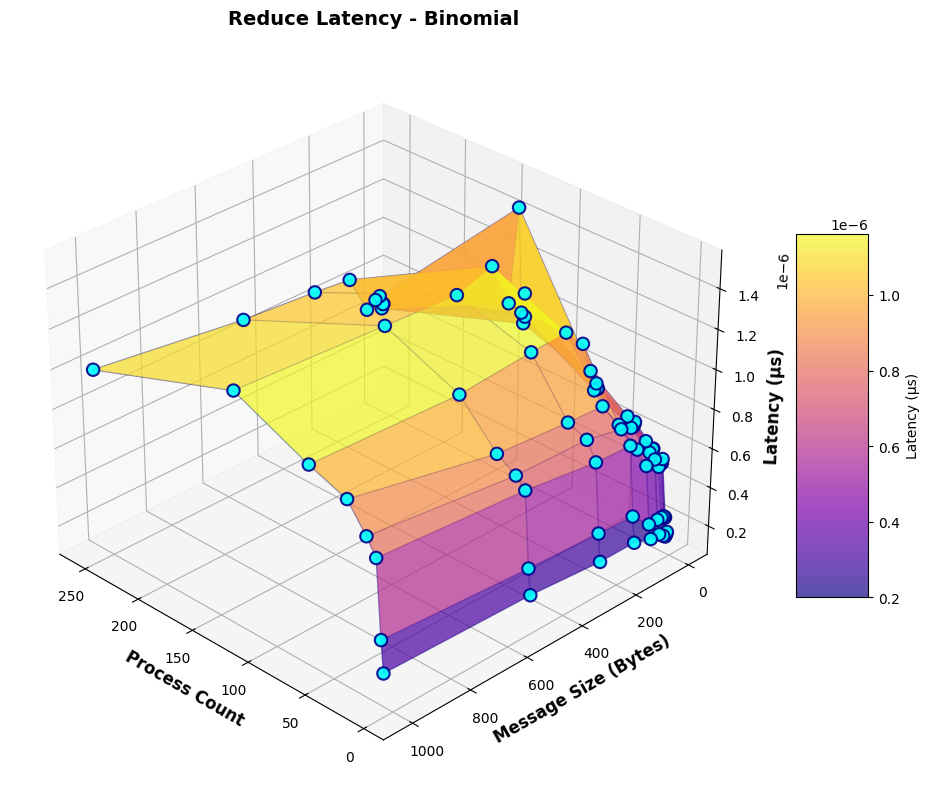

In [18]:
map3d_grid(df_reduce_var2, "Reduce Latency - Binomial")

### Rabenseifner

The **Rabenseifner algorithm total communication time** based on number of processes $n$ is given by a two-phase algorithm combining reduce-scatter and allgather:

**Phase 1 - Reduce-Scatter (Recursive Halving):**
$$T_{\text{reduce-scatter}}(n) = \sum_{i=0}^{\log_2 n - 1} \max_{R} \left\{ \ T(R \leftrightarrow R + 2^{lv}) \right\}$$

**Phase 2 - Allgather (Binomial Tree):**
$$T_{\text{allgather}}(n) = \sum_{lv=0}^{\log_2 n - 1} \max_{R} \left\{ \ T(R + 2^{lv} \to R) \right\}$$

**Total Latency:**
$$T(n) = T_{\text{reduce-scatter}}(n) + T_{\text{allgather}}(n)$$

with:
- $lv$ is the considered level (ranges from 0 to $\log_2 P - 1$)
- $R$ is the rank participating in communication
- $2^lv$ is the distance between sender and receiver at level $lv$ (so the step done)
- $\leftrightarrow$ is a bidirectional communication (exchange)
- $\to$ is a unidirectional communication (send)

**Explanation:** 
- **Phase 1:** Processes exchange data with partners at distance $2^i$, recursively reducing the problem size
- **Phase 2:** Results are gathered back using a binomial tree pattern
- At each level in both phases, the maximum latency across all parallel communications determines the level's completion time


In [19]:
# Model predictions across different process counts
rabenseifner_reduce_predictions = {}
for n_processes in range(2, 257):  # Sweep from 2 to 256 processes
    rabenseifner_reduce_predictions[n_processes] = rabenseifner_reduce_latency(
        matrix_times=LATENCY_MATRIX,
        num_cores=n_processes
    )

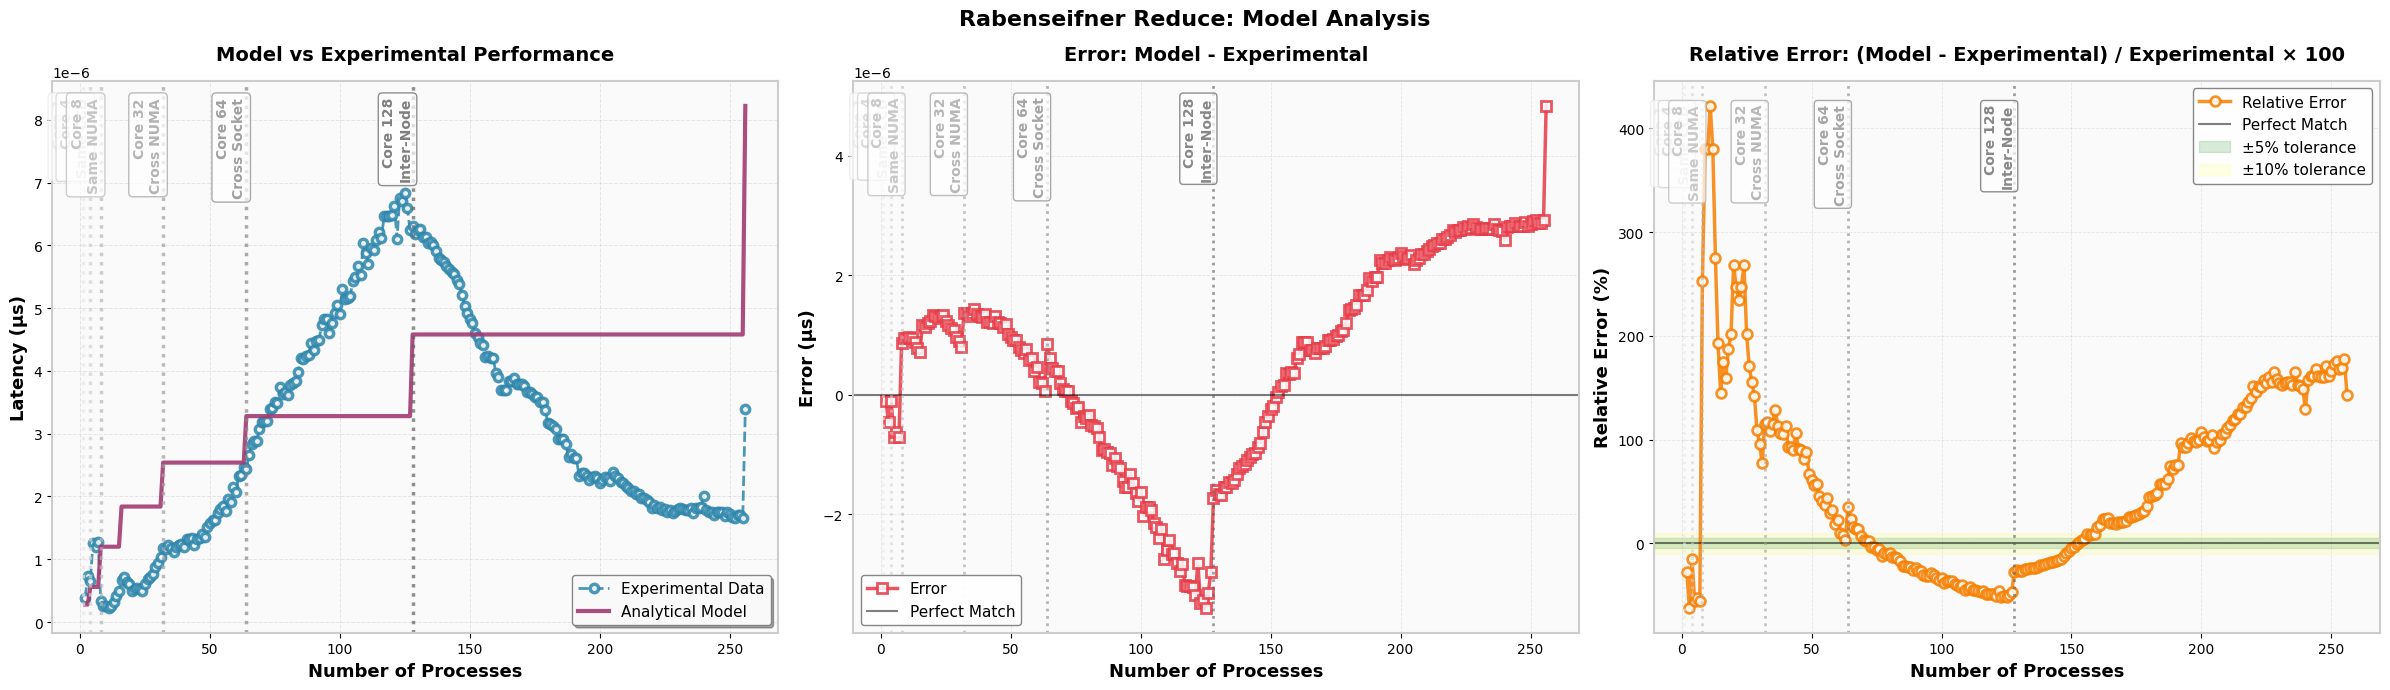

In [20]:
theory_and_experiment_plot_with_errors(df_reduce_fix3, rabenseifner_reduce_predictions, 'Rabenseifner Reduce',position_main='best', position_abs='lower left', position_rel='upper right')

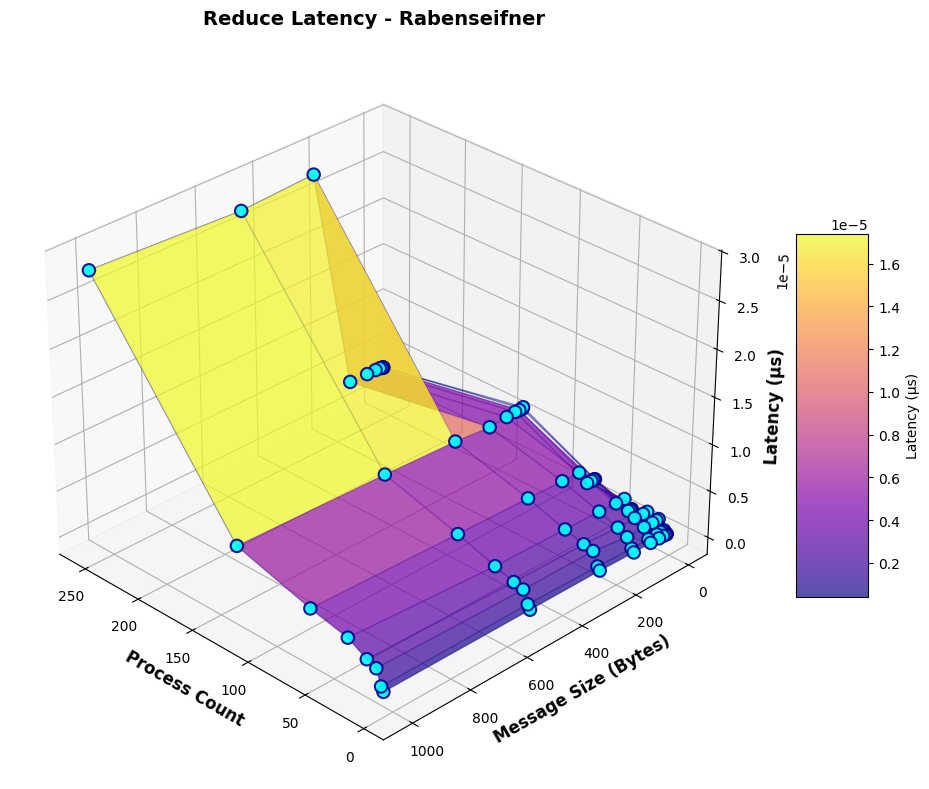

In [21]:
map3d_grid(df_reduce_var3, "Reduce Latency - Rabenseifner")